# Constantes y Logger

In [1]:
# %cd ~/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters

In [2]:
SAVE_FIGS = True  # If you want to save the figures.
RUN_MCMC = False  # If you want to run the MCMC's algorithms or use saved chains

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from icecream import ic
import time

import bwb.plotters as plotters

In [4]:
import torch
import numpy as np
import random

SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

torch.backends.cudnn.deterministic = True

In [5]:
from bwb import _logging as logging

log = logging.get_logger(__name__)

In [6]:
from pathlib import Path

CURR_PATH = Path().absolute()
print(f"{CURR_PATH = }")
BASE_PATH = CURR_PATH.parent.parent
print(f"{BASE_PATH = }")
DATA_PATH = BASE_PATH / "data"
print(f"{DATA_PATH = }")
NETS_PATH = BASE_PATH / "wgan_gp" / "networks" 
print(f"{NETS_PATH = }")
IMGS_PATH = CURR_PATH / "imgs" / "notebook-02"
IMGS_PATH.mkdir(parents=True, exist_ok=True)
print(f"{IMGS_PATH = }")
MCMC_PATH = BASE_PATH / "saved_mcmc"
print(f"{MCMC_PATH = }")
NUTS_PATH = MCMC_PATH / "NUTS"
print(f"{NUTS_PATH = }")

CURR_PATH = PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/examples/02-distribution-sampler')
BASE_PATH = PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters')
DATA_PATH = PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/data')
NETS_PATH = PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/wgan_gp/networks')
IMGS_PATH = PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/examples/02-distribution-sampler/imgs/notebook-02')
MCMC_PATH = PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/saved_mcmc')
NUTS_PATH = PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/saved_mcmc/NUTS')


In [7]:
from bwb.config import conf

conf.use_single_precision()
conf.set_eps(1e-20)
conf

Config(dtype=torch.float32, device=cuda:0, eps=1.00e-20)

# Sampleador de Distribuciones Posterior

Al igual que los muestreadores de distribuciones anteriores, los muestreadores a posteriori heredan de `bwb.distributions.distribution_samplers.DistributionSampler`. En este caso, tenemos a la clase abstracta
`bwb.distributions.posterior_samplers.BaseLatentMCMCPosteriorSampler` que define un MCMC utilizando la librería `hamiltorch`.

Al igual que en `bwb.distributions.distribution_samplers.GeneratorDistribSampler`, la forma de ajustar esta clase es con un generador `generator`, una transformación `transform_out`, un muestreador de ruido `noise_sampler` y datos para la posterior `data`.

## Obtener el modelo para muestrear los datos

Definimos el Dataset para obtener la primera cara y poder muestrear de ella

torch.Size([32, 32])


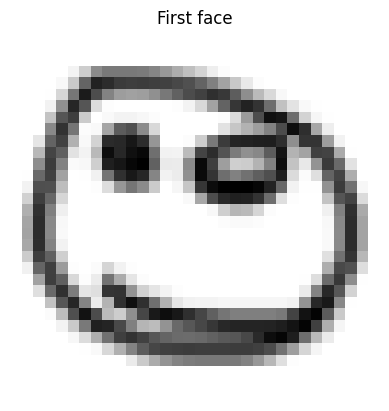

In [8]:
from quick_torch import QuickDraw
import torchvision.transforms.v2 as T
from pathlib import Path

transforms = T.Compose([
    T.ToImage(),
    T.Resize(32),
    T.ToDtype(torch.float32, scale=True),
    T.Lambda(lambda x: x.squeeze()),
])

ds = QuickDraw(
    DATA_PATH,
    categories="face",
    download=True,
    transform=transforms,
)

# You can use the wrapper to transform the usual DataSet into a model set
from bwb.distributions.models import ModelDataset

ds = ModelDataset(ds)

first_face = ds.get(0)
print(first_face.shape)
_ = plotters.plot_draw(ds.get(0), title="First face")

Obtenemos una muestra y lo graficamos en un histograma

## Obtener data

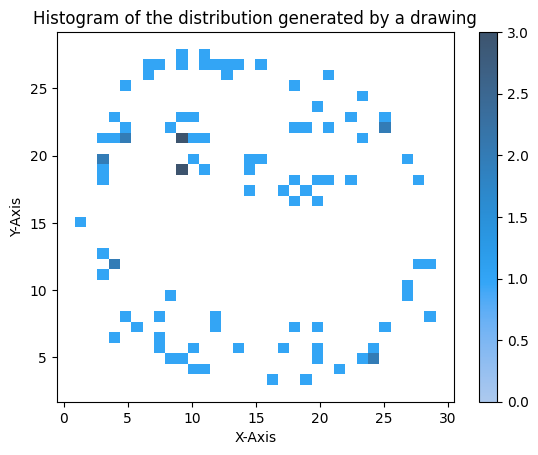

In [9]:
N_DATA = 100
data = first_face.sample((N_DATA,))

shape = first_face.shape
data_coords = first_face.enumerate_support_()[data].cpu().numpy() + np.random.randn(len(data), 2) * 0.1

plotters.plot_histogram_from_points(data_coords, rotate=True, shape=shape, histplot_kwargs=dict(bins=shape[0]))
plt.show()

# Definir red neuronal generadora y transformador

Se define la red neuronal de la misma manera que en el notebook anterior

In [10]:
from wgan_gp.wgan_gp_vae.model_resnet import Generator, Encoder, LatentDistribution
import torch
from wgan_gp.wgan_gp_vae.utils import load_checkpoint


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NOISE = "norm"
LATENT_DIM = 128
CHANNELS_IMG = 1
NUM_FILTERS = [256, 128, 64, 32]

noise_sampler = LatentDistribution(NOISE, LATENT_DIM, device)

G = Generator(LATENT_DIM, CHANNELS_IMG, latent_distr=NOISE).to(device)
E = Encoder(LATENT_DIM, CHANNELS_IMG).to(device)

DS_NAME = "data"
FACE_PATH = NETS_PATH / f"cleaned_{DS_NAME}_zDim{LATENT_DIM}_{NOISE}_bs_128"

load_checkpoint(G, FACE_PATH, "generator", device)
load_checkpoint(E, FACE_PATH, "encoder", device)

G.eval(); E.eval()
print()

torch.float64


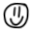

In [11]:
from bwb.distributions import DistributionDraw
from torchvision import disable_beta_transforms_warning
disable_beta_transforms_warning()

import torchvision.transforms.v2 as T


z = noise_sampler(1)
m = G(z)

transform_in = T.Compose([
    T.Lambda(lambda x: x / torch.max(x)),
    T.ToPILImage(),
    T.Resize(32),
    T.ToImage(),
    T.ConvertImageDtype(torch.float32),
    T.Normalize((0.5,), (0.5,)),
])

transform_out_ = T.Compose([
    T.ToDtype(torch.float64),
    T.Lambda(lambda x: x.squeeze()),
    T.Lambda(lambda x: x - torch.min(x)),
    T.Lambda(lambda x: x / torch.sum(x)),
])

transform_out = T.Compose([
    transform_out_,
    T.Lambda(lambda x: DistributionDraw.from_grayscale_weights(x)),
])

out: DistributionDraw = transform_out(m)
print(out.dtype)
out

# Definir el muestreador de distribuciones

In [12]:
BURN = 2_000
NUM_SAMPLES = 10_000
N_WALKERS = 1

In [13]:
from bwb.distributions.posterior_samplers import NUTSPosteriorSampler

In [18]:
NUTS_POSTERIOR_PATH = NUTS_PATH / f"burn-{BURN:_}-num_samples-{NUM_SAMPLES:_}-n_walkers-{N_WALKERS}"
NUTS_POSTERIOR_PATH = NUTS_POSTERIOR_PATH.with_suffix(".pkl.gz")
print(NUTS_POSTERIOR_PATH)

if not NUTS_POSTERIOR_PATH.exists() or RUN_MCMC:
    post_pi_n = NUTSPosteriorSampler(
        n_walkers=N_WALKERS,
        num_steps_per_sample=1,
        burn=BURN,
        desired_accept_rate=0.6,
    ).fit(
        G, transform_out_, noise_sampler, data,
    )
    
    post_pi_n.run(
        n_steps=NUM_SAMPLES,
    )

    tic = time.perf_counter()
    post_pi_n.save(NUTS_POSTERIOR_PATH)
    toc = time.perf_counter()
    ic(toc - tic)
    
else:
    post_pi_n = NUTSPosteriorSampler.load(NUTS_POSTERIOR_PATH)
    post_pi_n.fit(G, transform_out_, noise_sampler, data)

post_pi_n

/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/saved_mcmc/NUTS/burn-2_000-num_samples-10_000-n_walkers-1.pkl.gz


NUTSPosteriorSampler(n_data=100, len_chain=10_000, n_steps=10_000)

In [19]:
mean_autocorr_time = int(post_pi_n.get_autocorr_time().mean())
print(mean_autocorr_time)

2024-04-23 12:09:44,502: WARNING [bwb.utils:189]
> The chain is shorter than 50 times the integrated autocorrelation time for 128 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: tensor([ 472.5443,  229.6959,  544.7927,  591.8123,  440.1819, 1046.9225,
         607.9175,  220.6777,  890.0178,  342.9189,  767.9253, 1022.9805,
         970.7808, 1100.9065,  755.7792,  329.0177, 1035.9188,  427.0898,
         319.3095,  770.3057,  647.3923,  679.7635,  384.9914,  302.7645,
         658.7474,  459.0374,  883.6699,  688.8541,  358.5432,  532.0397,
         383.4472,  235.9787,  542.3302,  489.2892,  459.9972,  438.5709,
        1043.2183,  301.6845, 1069.1885, 1247.9983,  701.6076,  393.0209,
         491.4072,  712.1945, 1239.2010, 1019.2840,  437.5804,  298.0584,
         615.7383,  982.0928,  837.5525,  327.5558, 1194.5491,  696.9542,
         762.1111,  765.8965,  582.6609,  395.4280,  218.9255,  517.8450,
         870.7594,  546.0482,  472.5673,  46

631


In [20]:
post_pi_n.shuffle_samples_cache(thin=int(mean_autocorr_time / 10))

NUTSPosteriorSampler(n_data=100, n_cached_samples=159, len_chain=10_000, n_steps=10_000)

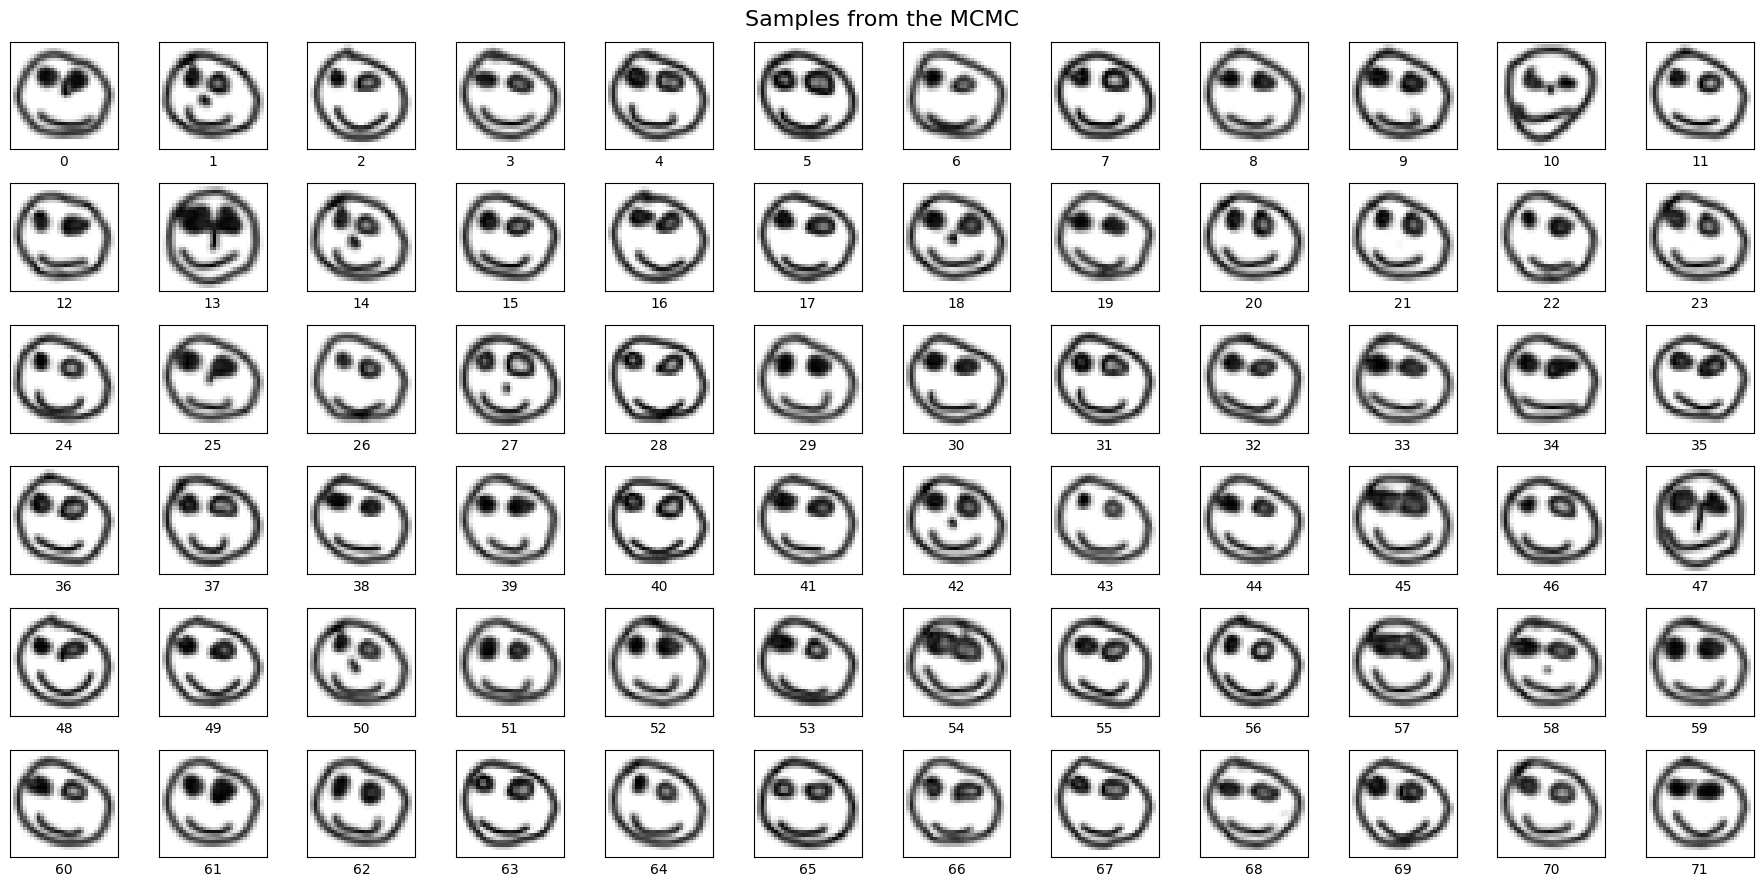

In [21]:
n_rows, n_cols = 6, 12
max_imgs = n_rows * n_cols
fig, ax = plotters.plot_list_of_draws(
    post_pi_n.rvs(max_imgs), 
    n_rows=n_rows, n_cols=n_cols,
    title=f"Samples from the MCMC"
)

In [22]:
if SAVE_FIGS:
    PATH_TO_SAVE = IMGS_PATH / f"{post_pi_n.__class__.__name__}-{n_rows}x{n_cols}"
    fig.savefig(PATH_TO_SAVE.with_suffix(".pdf"))
    fig.savefig(PATH_TO_SAVE.with_suffix(".png"))